## Lock Jun Lin 0125118

# Twitter Sentiment Analysis on COVID-19 Vaccine (LR, MNB) (TF-IDF, Word2Vec)

This notebook is regarding the development of twitter sentiment analysis model. Several different machine learning algorithm are used for developing the model in order to perform a comparison between different models to determine which machine learning algorithm is most suitable to develop the best performing model. This notebook will consists of only supervised machine learning algorithm. The machine learning algorithms applied in this notebook are Logistic Regression and Multinomial Naive Bayes. The model will use a labelled training dataset as the machine learning algorithms applied are all supervised machine learning algorithm. Text cleaning/pre-processing will be performed on the text data of the dataset. The dataset contains 3 different labels or classes tweets/data which are negative, neutral, and positive. A 4th label/class - "Irrelevant" can be found in the dataset but all tweets under that label/class will be remove as it is not necessary for model training. The model is to predict 3 different classes of tweets. The training dataset has almost 70,000 rows of data. 

The training dataset can be found from this [link](https://www.kaggle.com/tanujdhiman/twitter-sentiment-analysis/data).

Exploratory Data Analysis is also performed in order to gain a deeper insight towards the dataset that will be used for training the model. The vectorizer or feature extraction algorithm that will be used is TF-IDF (Term Frequency-Inverse Document Frequency) algorithm and Word2Vec (word embedding) algorithm. Evaluation metrics and confusion matrix will be used to evaluate the different model and compared each model with the evaluation metric score of respective models.

Another twitter sentiment analysis model is also developed by using a deep learning model, which is BERT model. BERT model is a transformer model and it should be able to perform much better compared to these machine learning algorithm. As such, if the twitter sentiment analysis model that is developed using BERT model has better performance than the models in this notebook, it will be then decided that the BERT model will be chosen as the model to be used for developing the twitter sentiment analysis model.

In [1]:
#import required libraries for this project

# utilities
import re #regex version 2021.3.17
import numpy as np # linear algebra  #numpy 1.18.5
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)  #pandas version 1.2.3
import matplotlib.pyplot as plt # data visualization library   # matplotlib version 3.3.4
%matplotlib inline
import seaborn as sns # interactive visualization library built on top on matplotlib  #seaborn version 0.11.1
sns.set(style="darkgrid")
sns.set(font_scale=1.5)
from wordcloud import WordCloud  #wordcloud 1.8.1
import string   
import collections 
from pprint import pprint
from time import time

#nltk version 3.5
import nltk
# nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import gensim

#scikit-learn version 0.24.1
# sklearn for model training
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn import model_selection

# sklearn evaluation metrics
from sklearn.metrics import classification_report,accuracy_score, plot_confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

# lime version 0.2.0.1
# lime explainable AI for explaining result of prediction by machine learning model
import lime
from lime.lime_text import LimeTextExplainer

# pickleshare version 0.7.5
# pickle library for exporting model into pkl file
import pickle

#warnings
import warnings
warnings.filterwarnings('ignore')

## Exploratory Data Analysis (EDA)

### This was done to examine and analyze the tweet dataset to develop a deeper understanding about dataset.

Tweets are labelled with 3 different labels that represents the type of tweet. Those labels are 'negative', 'neutral', and 'positive'.

In [2]:
#column names for the dataset
colnames = ['id', 'entity', 'sentiment', 'text']
df = pd.read_csv('twitter_training.csv', names=colnames, header=None)
df.head() #display first 5 rows of dataset

#remove tweet labels as "Irrelevant"
df = df[df.sentiment != 'Irrelevant']

# Convert the string "label" column to category column
df['sentiment'] = df["sentiment"].astype('category')

# Displaying dataset information and display first 5 row of dataset
print('Size of tweet dataset:', df.shape, '\n')
print(df.info())

# Check for Missing Values in dataset If Any
print("\nRows with empty column data in dataset:\n", df.isna().sum())

#extract necessary column from dataset into new dataframe and rename column name and drop rows without sentiment value
df_tweets = df[['text', 'sentiment']].dropna().reset_index(drop=True)
df_tweets['sentiment'] = df_tweets['sentiment'].map({'Negative' : 'negative',
                                                     'Neutral' : 'neutral', 'Positive' : 'positive'})

df_tweets.head(5) #show first 5 rows of dataset

Size of tweet dataset: (61692, 4) 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61692 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   id         61692 non-null  int64   
 1   entity     61692 non-null  object  
 2   sentiment  61692 non-null  category
 3   text       61121 non-null  object  
dtypes: category(1), int64(1), object(2)
memory usage: 1.9+ MB
None

Rows with empty column data in dataset:
 id             0
entity         0
sentiment      0
text         571
dtype: int64


,text,sentiment
0,im getting on borderlands and i will murder yo...,positive
1,I am coming to the borders and I will kill you...,positive
2,im getting on borderlands and i will kill you ...,positive
3,im coming on borderlands and i will murder you...,positive
4,im getting on borderlands 2 and i will murder ...,positive


### Distribution of target variable (negative, neutral, and positive label)

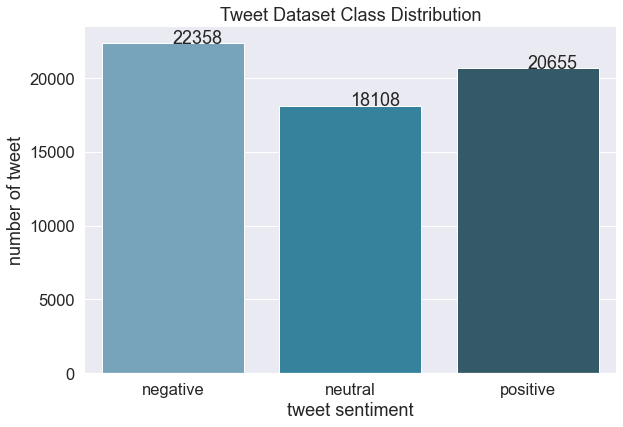

In [3]:
#plot the graph to show how many tweets in respective classes are there in the tweet dataset
sns.catplot(x="sentiment", data=df_tweets, kind="count", height=6, aspect=1.5, palette="PuBuGn_d")
plt.xlabel("tweet sentiment")
plt.text(0, df_tweets.sentiment.value_counts()[0], df_tweets.sentiment.value_counts()[0])
plt.text(2, df_tweets.sentiment.value_counts()[1], df_tweets.sentiment.value_counts()[1])
plt.text(1, df_tweets.sentiment.value_counts()[2], df_tweets.sentiment.value_counts()[2])
plt.ylabel("number of tweet")
plt.title("Tweet Dataset Class Distribution")
plt.show()

### Graph of distribution of the number of words in a tweet per label class

Word Count
Negative: 20.047141962608464
Positive: 17.190462357782618
Neutral: 20.248453722111773
Character Count
Negative: 111.28571428571429
Positive: 95.92616799806342
Neutral: 118.8346034901701
Unique Word Count
Negative: 18.312997584757134
Positive: 15.81370128298233
Neutral: 18.4412966644577


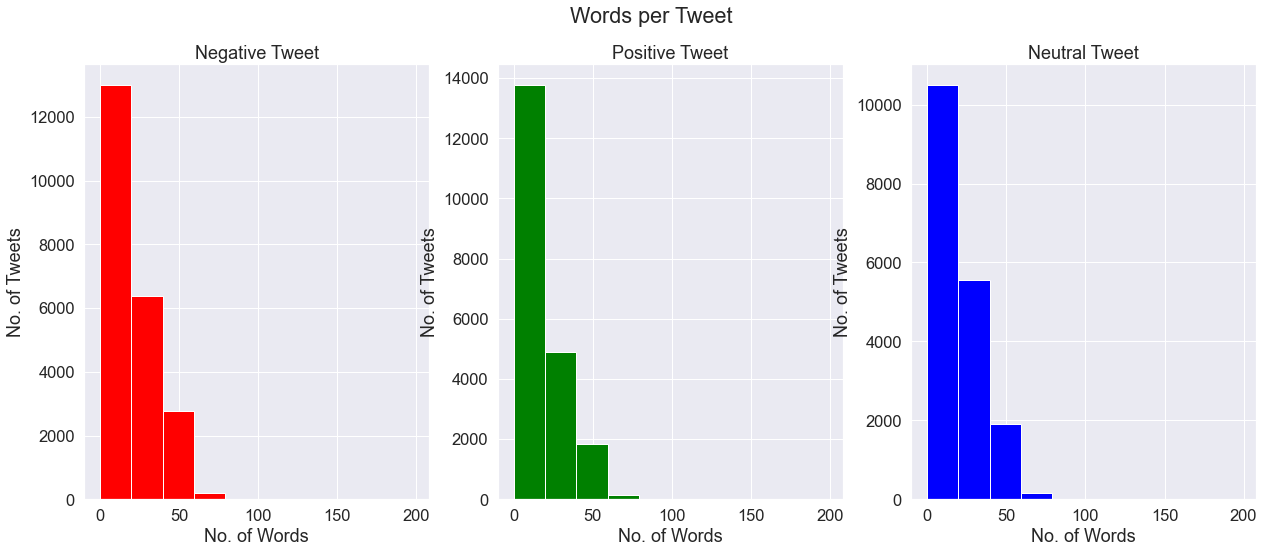

In [4]:
#show word count, character count, and unique word-count of tweet
#1. WORD-COUNT
df_tweets['word_count'] = df_tweets['text'].apply(lambda x: len(str(x).split()))
print("Word Count")
print("Negative:", df_tweets[df_tweets['sentiment']=="negative"]['word_count'].mean()) #negative tweet
print("Positive:", df_tweets[df_tweets['sentiment']=="positive"]['word_count'].mean()) #positive tweet
print("Neutral:", df_tweets[df_tweets['sentiment']=="neutral"]['word_count'].mean()) #neutral tweet
print("========")

#2. CHARACTER-COUNT
df_tweets['char_count'] = df_tweets['text'].apply(lambda x: len(str(x)))
print("Character Count")
print("Negative:", df_tweets[df_tweets['sentiment']=="negative"]['char_count'].mean()) #negative tweet
print("Positive:", df_tweets[df_tweets['sentiment']=="positive"]['char_count'].mean()) #positive tweet
print("Neutral:", df_tweets[df_tweets['sentiment']=="neutral"]['char_count'].mean()) #neutral tweet
print("========")

#3. UNIQUE WORD-COUNT
df_tweets['unique_word_count'] = df_tweets['text'].apply(lambda x: len(set(str(x).split())))
print("Unique Word Count")
print("Negative:", df_tweets[df_tweets['sentiment']=="negative"]['unique_word_count'].mean()) #negative tweet
print("Positive:", df_tweets[df_tweets['sentiment']=="positive"]['unique_word_count'].mean()) #positive tweet
print("Neutral:", df_tweets[df_tweets['sentiment']=="neutral"]['unique_word_count'].mean()) #neutral tweet

#Plotting word-count per tweet according to label of tweet
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(21,8))
train_words=df_tweets[df_tweets['sentiment']=="negative"]['word_count']
ax1.hist(train_words,color='red')
ax1.set_title('Negative Tweet')
ax1.set_xlabel('No. of Words')
ax1.set_ylabel('No. of Tweets')

train_words=df_tweets[df_tweets['sentiment']=="positive"]['word_count']
ax2.hist(train_words,color='green')
ax2.set_title('Positive Tweet')
ax2.set_xlabel('No. of Words')
ax2.set_ylabel('No. of Tweets')

train_words=df_tweets[df_tweets['sentiment']=="neutral"]['word_count']
ax3.hist(train_words,color='blue')
ax3.set_title('Neutral Tweet')
ax3.set_xlabel('No. of Words')
ax3.set_ylabel('No. of Tweets')
fig.suptitle('Words per Tweet')

plt.show()

### Graph of word frequency of tweet text data

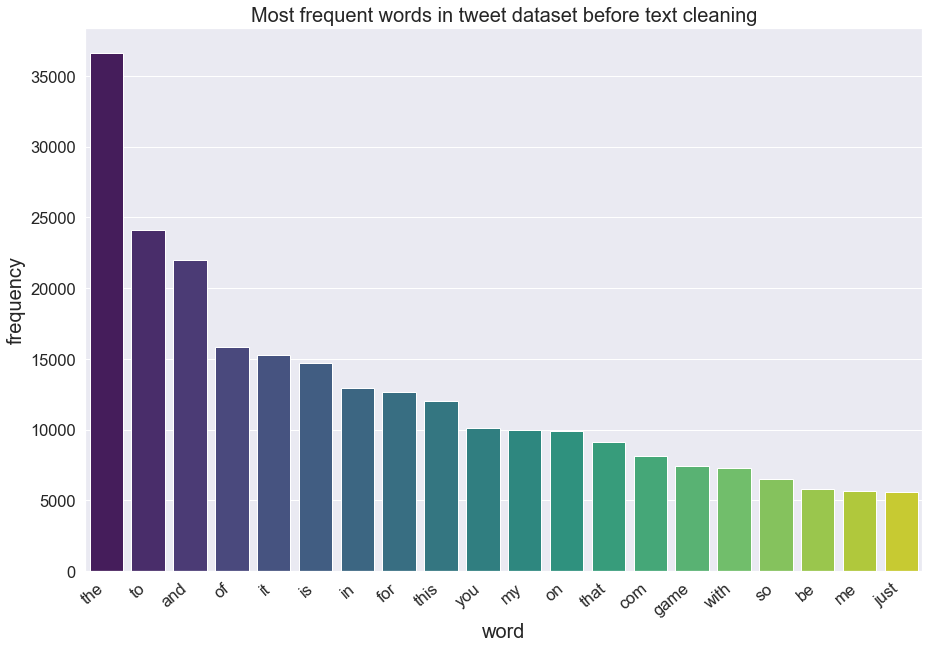

In [5]:
#define function to vectorize text and calculate the most frequent text in tweet text data
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

#get 20 most frequent words in tweet text data before text cleaning
common_words = get_top_n_words(df_tweets['text'], 20)
df1 = pd.DataFrame(common_words, columns = ['text' , 'count'])
#plot graph to show frequency of 20 most frequent words in tweet text data before text cleaning
fig, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x="text", y="count", data=df1, palette="viridis", ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.title("Most frequent words in tweet dataset before text cleaning", fontsize=20)
plt.ylabel("frequency", fontsize=20)
plt.xlabel("word", fontsize=20)
plt.show()

In [6]:
#define a class, TextCounts to analyze the tweet text attribute
class TextCounts(BaseEstimator, TransformerMixin):
    
    def count_regex(self, pattern, tweet):
        return len(re.findall(pattern, tweet))
    
    def fit(self, X, y=None, **fit_params):
        # fit method is used when specific operations need to be done on the train data, but not on the test data
        return self
    
    def transform(self, X, **transform_params):
        #count the number of words in each tweet
        count_words = X.apply(lambda x: self.count_regex(r'\w+', x)) 
        df = pd.DataFrame({'count_words': count_words})
        return df
    
#define object of TestCounts class
tc = TextCounts()
#define new dataframe to store result of analysis of tweet text
df_eda = tc.fit_transform(df_tweets.text)
df_eda['sentiment'] = df_tweets.sentiment

### Graph of distribution of number of words in each negative, neutral, and positive tweets

Descriptive stats for count_words
---------------------------------
             count       mean        std  min   25%   50%   75%    max
sentiment                                                             
negative   22358.0  20.301771  14.930195  0.0   8.0  16.0  29.0  107.0
neutral    18108.0  20.592611  13.812406  0.0  11.0  18.0  28.0  198.0
positive   20655.0  17.474897  14.165371  0.0   7.0  14.0  24.0  198.0


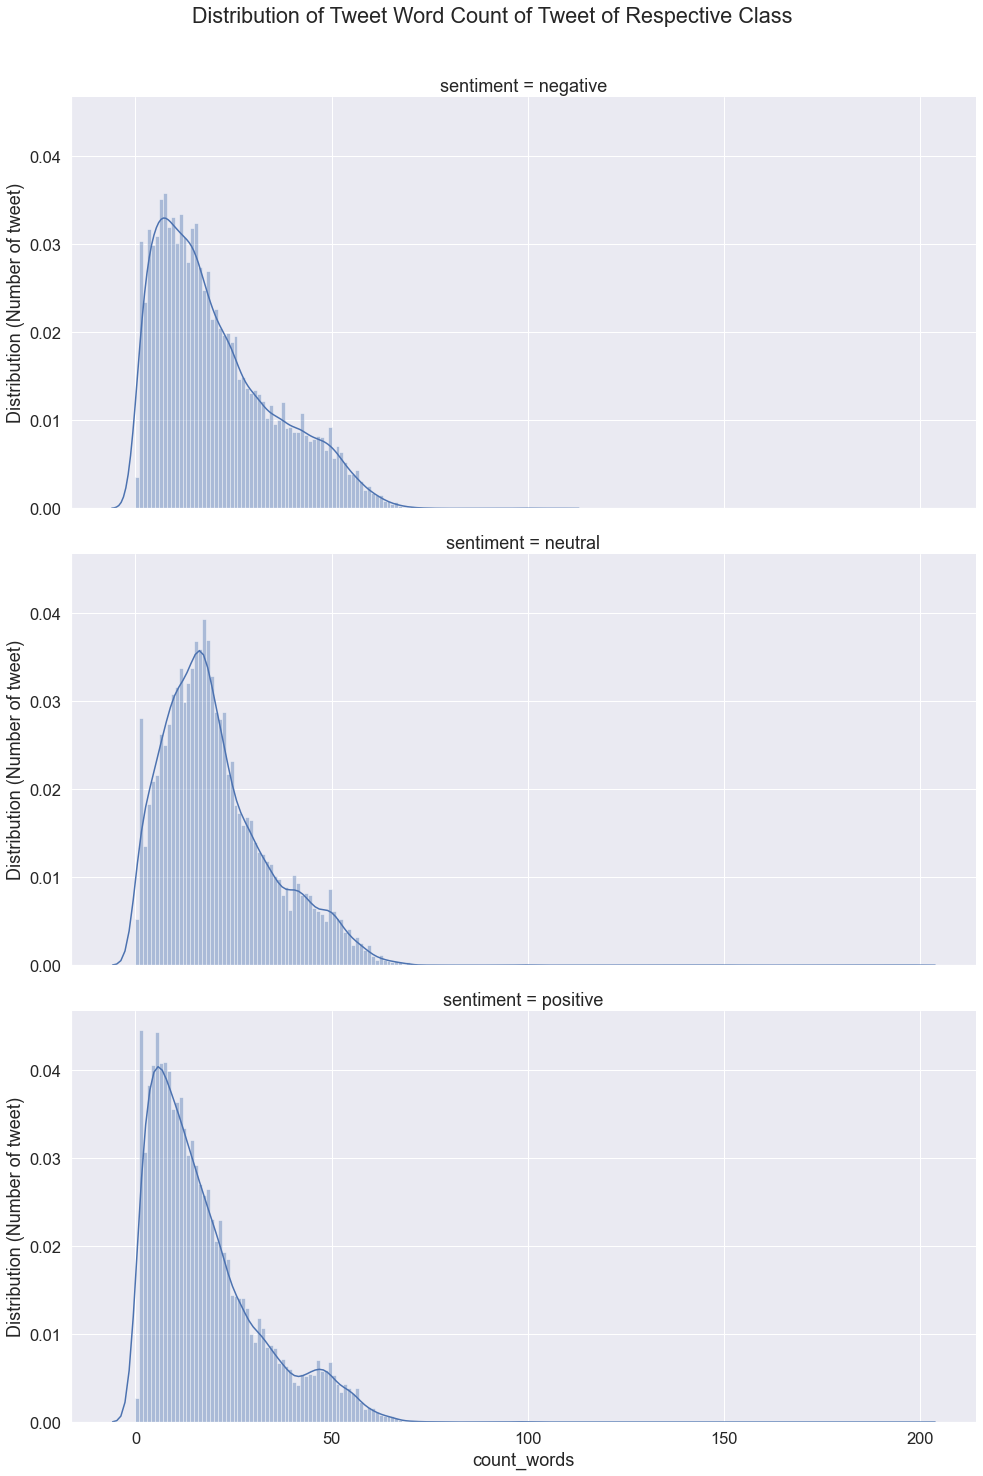

In [7]:
#define function to display graph to visualize word count of tweet of respective class
def show_dist(df, col):
    print('Descriptive stats for {}'.format(col))
    print('-'*(len(col)+22))
    print(df.groupby('sentiment')[col].describe())
    bins = np.arange(df[col].min(), df[col].max() + 1)
    g = sns.FacetGrid(df, row='sentiment', size=7, aspect=2)
    g = g.map(sns.distplot, col, kde=True, norm_hist=True, bins=bins)
    g.axes[0,0].set_xlabel("Number of words per tweet")
    g.axes[0,0].set_ylabel("Distribution (Number of tweet)")
    g.axes[1,0].set_ylabel("Distribution (Number of tweet)")
    g.axes[2,0].set_ylabel("Distribution (Number of tweet)")
    g.fig.subplots_adjust(top=0.92)
    g.fig.suptitle("Distribution of Tweet Word Count of Tweet of Respective Class")
    plt.style.use("seaborn-bright")
    plt.show()
    
#plot the graph of word count in each tweet
show_dist(df_eda, 'count_words')

In [8]:
# retriving text column and sentiment column from dataset as only these 2 column are needed for model training
df_tweets = df_tweets[["text","sentiment"]]
df_tweets.head(5)

,text,sentiment
0,im getting on borderlands and i will murder yo...,positive
1,I am coming to the borders and I will kill you...,positive
2,im getting on borderlands and i will kill you ...,positive
3,im coming on borderlands and i will murder you...,positive
4,im getting on borderlands 2 and i will murder ...,positive


## Text Data Preprocessing on Tweet Text Data to Convert Raw Data to Usable Data

1. Remove punctuations mark.
2. Remove all digits or numbers.
3. Remove stopwords (list of words that do not have any meaning such as a, about, above, etc.).
4. Change multiple spaces into single space.
5. Remove all special characters and emojis. (ex: star symbol)
6. Remove urls and *@mentions* that are often found in tweets 
7. Lowercase all character in tweet text data.
8. Perform lemmatization on the text data to revert the words to its root words.

- A class is define with all the text processing technique and it is applied to the tweet text data

In [9]:
#define a CleanText class to perform data cleaning on tweet text data from data set
class CleanText(BaseEstimator, TransformerMixin):
    
    #remove emoji
    def remove_emoji(self, input_text):
        return input_text.encode('ascii', 'ignore').decode('ascii')
    
    #remove mentions in tweets
    def remove_mentions(self, input_text):
        return re.sub(r'@\w+', '', input_text)
    
    # remove url link in tweets
    def remove_urls(self, input_text):
        return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
    
    #remove all punctuation from tweet text data
    def remove_punctuation(self, input_text):
        # Make translation table
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)
    
    #remove all digit from tweet text data
    def remove_digits(self, input_text):
        return re.sub('\d+', '', input_text)
    
    #change all letter in tweet text data to lowercase
    def to_lower(self, input_text):
        return input_text.lower()
    
    #remove of leading/trailing whitespace 
    def remove_space(self, input_text):
        return input_text.strip()
    
    #remove extra spaces
    def remove_extra_space(self, input_text):
        return re.sub(r'\s+', ' ', input_text, flags=re.I)
    
    #remove special character
    def remove_special_char(self, input_text):
        return re.sub(r'\W', ' ' , input_text)
    
    #remove all stopwords such as to, i, me, etc. from tweet text data
    def remove_stopwords(self, input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words)
    
    #perform lemmatization on each word in tweet text data to return each word back to its root word without changing the meaning of the word
    def word_lemmatization(self, input_text):
        lemmatizer = WordNetLemmatizer()
        words = input_text.split()
        lemmed_words = [lemmatizer.lemmatize(word) for word in words]
        return " ".join(lemmed_words)
     
    def fit(self, X, y=None, **fit_params):
        return self
    
    #apply each function in CleanText class to the text dataframe
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.remove_emoji).apply(self.remove_mentions).apply(self.remove_urls).apply(
            self.remove_punctuation).apply(self.remove_digits).apply(self.to_lower).apply(self.remove_space).apply(
            self.remove_extra_space).apply(self.remove_special_char).apply(self.remove_stopwords).apply(
            self.word_lemmatization)
        return clean_X

In [10]:
#define object of CleantText class
ct = CleanText()
sr_clean = ct.fit_transform(df_tweets.text)
#display 5 random data of the tweet text data that has gone through data cleaning
print("Sample of data after data cleaning:-\n",sr_clean.sample(5))
#check if there any rows from the dataset has does not have any words left for tweet attribute
empty_clean = sr_clean == ''
print('\n{} tweets have zero words after going though text cleaning.'.format(sr_clean[empty_clean].count()))

Sample of data after data cleaning:-
 14639                                p gon last longer nut
56386          seriously insane already looking incredible
50390    no escape cursed land keep living shithole eve...
12436                                        lovely number
17176                          fuck relapse world warcraft
Name: text, dtype: object

1463 tweets have zero words after going though text cleaning.


### Writing cleaned tweet and the label of the tweet to new csv file

In [11]:
#define a new dataframe to store the cleaned tweet text data and sentiment value of tweet
df_cleaned = pd.DataFrame({'clean_text': sr_clean, 'sentiment': df_tweets["sentiment"]})
df_cleaned.columns.tolist()

#Drop rows that has tweet text with no words after text preprocessing
df_cleaned.drop(df_cleaned[df_cleaned.clean_text == ""].index, inplace=True)
df_cleaned.info()

#write cleaned tweet text data and label of tweet to new csv file
df_cleaned.to_csv("cleaned_tweet_dataset.csv", index=False)
df_cleaned.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59658 entries, 0 to 61120
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   clean_text  59658 non-null  object  
 1   sentiment   59658 non-null  category
dtypes: category(1), object(1)
memory usage: 990.5+ KB


,clean_text,sentiment
0,im getting borderland murder,positive
1,coming border kill,positive
2,im getting borderland kill,positive
3,im coming borderland murder,positive
4,im getting borderland murder,positive


## Analyze Tweet Text Data after Text Preprocessing

- Plot text frequency graph of tweet text data after text data preprocessing.

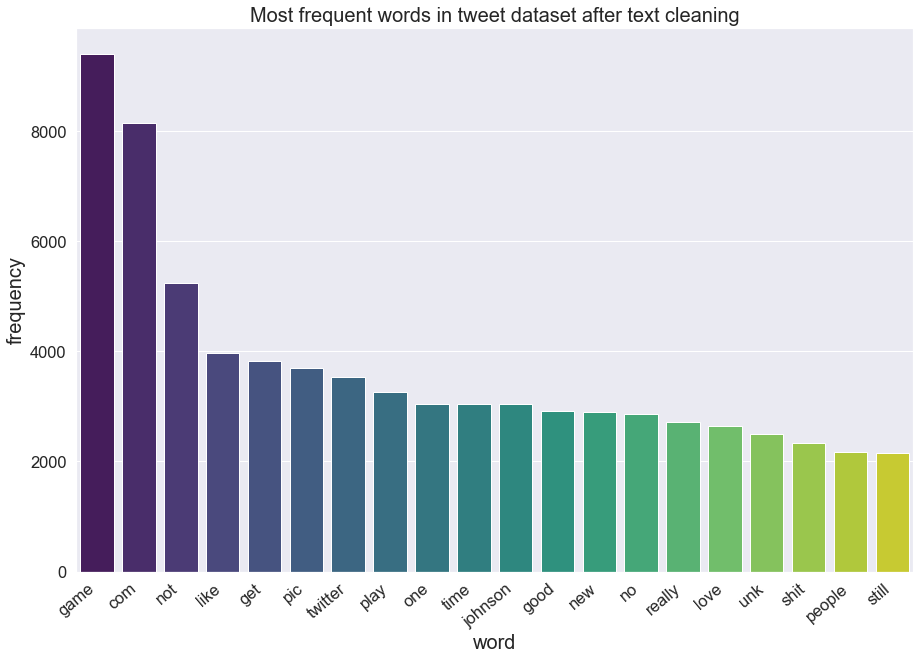

In [12]:
#define function to vectorize text and calculate the most frequent text in tweet text data (after text preprocessing)
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

#get 20 most frequent words in tweet text data after text cleaning
common_words = get_top_n_words(df_cleaned['clean_text'], 20)
df1 = pd.DataFrame(common_words, columns = ['text' , 'count'])
#plot graph to show frequency of 20 most frequent words in tweet text data after text cleaning
fig, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x="text", y="count", data=df1, palette="viridis", ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.title("Most frequent words in tweet dataset after text cleaning", fontsize=20)
plt.ylabel("frequency", fontsize=20)
plt.xlabel("word", fontsize=20)
plt.show()

## Model Building

- The machine learning algorithms used are Logistic Regression and Multinomial Naive Bayes.
- The confusion matrix constructed from the prediction of the trained models.
- The metrics score are printed as well to evaluate the performance of the trained models.
- The vectorizer/feature extraction algorithm used is TF-IDF and Word2Vec.
- Hyperparameter tuning and cross validation is performed for training of each respective models and tf-idf feature extraction algorithm method to determine the best optimal parameter for the machine learning algorithm and tf-idf algorithm.

In [13]:
#define ColumnExtractor class to extract column from dataframe
class ColumnExtractor(TransformerMixin, BaseEstimator):
    def __init__(self, cols):
        self.cols = cols
    def transform(self, X, **transform_params):
        return X[self.cols]
    def fit(self, X, y=None, **fit_params):
        return self
    
#spliting dataset into test data and train data with 20% of data as test data
X_train, X_test, y_train, y_test = train_test_split(df_cleaned.drop('sentiment', axis=1), 
                                                    df_cleaned.sentiment, test_size=0.2, random_state=37)

In [14]:
#define a grid_vect function to train the model using different parameters and cross validation to get the optimal parameters for the machine learning algorithm
#the function will also print out the results of the training and show which parameter produces the best model with the highest accuracy
#Based on http://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html
def grid_vect(clf, parameters_clf, X_train, X_test, parameters_text=None, vect=None, is_w2v=False):
    if is_w2v:  #Word2Vec
        w2vcols = []
        for i in range(SIZE):
            w2vcols.append(i)
        features = FeatureUnion([('w2v', ColumnExtractor(cols=w2vcols))], n_jobs=-1)
    else:
            features = FeatureUnion([('pipe', Pipeline([('cleantext', ColumnExtractor(cols='clean_text')), ('vect', vect)]))]
                                , n_jobs=-1)
    
    pipeline = Pipeline([('features', features), ('clf', clf)])
    
    # Join the parameters dictionaries together
    parameters = dict()
    if parameters_text:
        parameters.update(parameters_text)
    parameters.update(parameters_clf)
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=5)
    
    print("=================Performing grid search...========================")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    #pprint the parameters that are applied to the machine learning model to determine the best optimal parameters
    pprint(parameters)
    t0 = time()
    grid_search.fit(X_train, y_train)
    #print time taken to complete Hyperparameter tuning and cross-validation
    print("done in %0.3fs" % (time() - t0))
    print()
    print("Best CV score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
    print("Test score with best_estimator_: %0.3f" % grid_search.best_estimator_.score(X_test, y_test))
    return grid_search

# Parameter grid settings for the TF-IDF vectorizers
parameters_vect = {
    'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
    'features__pipe__vect__ngram_range': ((1, 1), (1, 2)),
    'features__pipe__vect__min_df': (1,2)
}

# Parameter grid settings for MultinomialNB
parameters_mnb = {
    'clf__alpha': (0.25, 0.5, 0.75)
}

# Parameter grid settings for LogisticRegression
parameters_logreg = {
    'clf__C': (0.25, 0.5, 1.0),
    'clf__penalty': ('l1', 'l2')
}

### Word2Vec Model Training (Word Embedding)

In [15]:
#Word2Vec Model Training
SIZE = 150  #provide size of Word2Vec

#tokenize text data
X_train['clean_text_wordlist'] = X_train.clean_text.apply(lambda x : word_tokenize(x))
X_test['clean_text_wordlist'] = X_test.clean_text.apply(lambda x : word_tokenize(x))

#train Word2Vec model
model = gensim.models.Word2Vec(X_train.clean_text_wordlist, min_count=2, size=SIZE, window=10, workers=10, sg=1)
model.train(X_train.clean_text_wordlist,total_examples=len(X_train.clean_text_wordlist),epochs=10)
print(model.most_similar('plane', topn=3))

#compute average Word2Vec vector for each word in text data
def compute_avg_w2v_vector(w2v_dict, tweet):
    list_of_word_vectors = [w2v_dict[w] for w in tweet if w in w2v_dict.vocab.keys()]
    if len(list_of_word_vectors) == 0:
        result = [0.0]*SIZE
    else:
        result = np.sum(list_of_word_vectors, axis=0) / len(list_of_word_vectors)
    return result

X_train_w2v = X_train['clean_text_wordlist'].apply(lambda x: compute_avg_w2v_vector(model.wv, x))
X_test_w2v = X_test['clean_text_wordlist'].apply(lambda x: compute_avg_w2v_vector(model.wv, x))

#convert Word2Vec values into dataframe
X_train_w2v = pd.DataFrame(X_train_w2v.values.tolist(), index= X_train.index)
X_test_w2v = pd.DataFrame(X_test_w2v.values.tolist(), index= X_test.index)

[('freemode', 0.6976435780525208), ('kyoot', 0.6605828404426575), ('symmetrical', 0.6517544388771057)]


### Model Training

In [16]:
#defining the object for TF-IDF vectorizer
tfidfvect = TfidfVectorizer()

#defining the object for each respective machine learning model class
mnb = MultinomialNB()
logreg = LogisticRegression()

# MultinomialNB + TF-IDF
print("TF-IDF Multinomial Naive Bayes Training...")
optimized_mnb_tfidf = grid_vect(mnb, parameters_mnb, X_train, X_test, parameters_text=parameters_vect, vect=tfidfvect)

# LogisticRegression + TF-IDF
print("====================================================================\n\nTF-IDF Logistic Regression Training...")
optimized_logreg_tfidf = grid_vect(logreg, parameters_logreg, 
                                  X_train, X_test, parameters_text=parameters_vect, vect=tfidfvect)

#Logistic Regression + Word2Vec
print("====================================================================\n\nWord2Vec Logistic Regression Training...")
optimized_logreg_w2v = grid_vect(logreg, parameters_logreg, X_train_w2v, X_test_w2v, is_w2v=True)

TF-IDF Multinomial Naive Bayes Training...
=================Performing grid search...========================
pipeline: ['features', 'clf']
parameters:
{'clf__alpha': (0.25, 0.5, 0.75),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 36 candidates, totalling 180 fits
done in 45.834s

Best CV score: 0.932
Best parameters set:
	clf__alpha: 0.25
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.945

TF-IDF Logistic Regression Training...
=================Performing grid search...========================
pipeline: ['features', 'clf']
parameters:
{'clf__C': (0.25, 0.5, 1.0),
 'clf__penalty': ('l1', 'l2'),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds f

### Confusion Matrix and Evaluation Metrics

Evaluation Metrics and confusion matrix of all trained model is generated to compare each and every model to determine which machine learning algorithm, using which training dataset, and using which feature extraction algorithm can produce the best performing model.

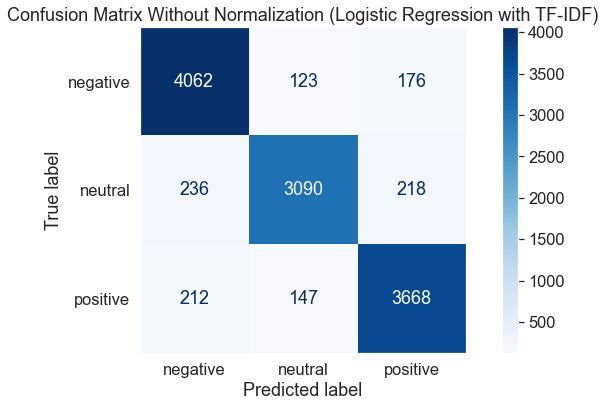

In [17]:
#Plotting a confusion matrix graph to to evaluate the logistic regression model with TF-IDF vectorizer
fig, ax = plt.subplots(figsize=(13, 6))
disp = plot_confusion_matrix(optimized_logreg_tfidf, X_test, y_test, cmap=plt.cm.Blues, normalize=None, ax=ax)
disp.ax_.set_title("Confusion Matrix Without Normalization (Logistic Regression with TF-IDF)")
#remove white grid lines from the graph
plt.grid(False)
plt.show()

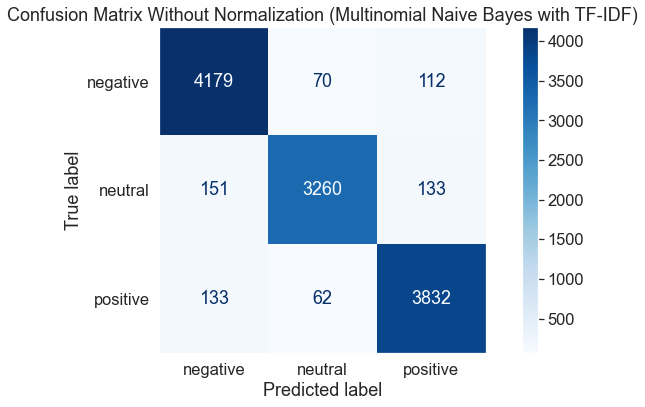

In [18]:
#Plotting a confusion matrix graph to to evaluate the multinomial naive bayes model with TF-IDF vectorizer
fig, ax = plt.subplots(figsize=(13, 6))
disp = plot_confusion_matrix(optimized_mnb_tfidf, X_test, y_test, cmap=plt.cm.Blues, normalize=None, ax=ax)
disp.ax_.set_title("Confusion Matrix Without Normalization (Multinomial Naive Bayes with TF-IDF)")
#remove white grid lines from the graph
plt.grid(False)
plt.show()

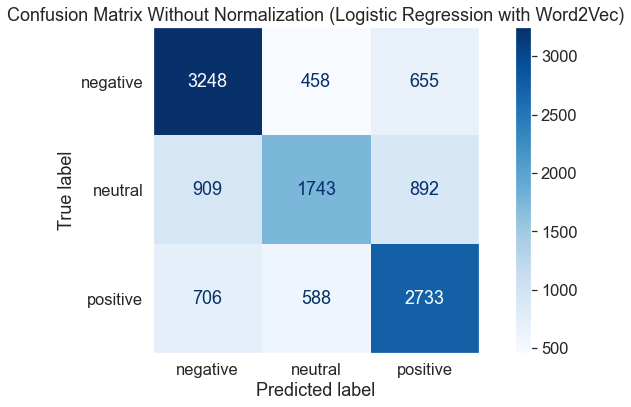

In [19]:
#Plotting a confusion matrix graph to to evaluate the logistic regression model with Word2Vec vectorizer
fig, ax = plt.subplots(figsize=(13, 6))
disp = plot_confusion_matrix(optimized_logreg_w2v, X_test_w2v, y_test, cmap=plt.cm.Blues, normalize=None, ax=ax)
disp.ax_.set_title("Confusion Matrix Without Normalization (Logistic Regression with Word2Vec)")
#remove white grid lines from the graph
plt.grid(False)
plt.show()

In [20]:
#compute the evaluation metric of the respective models (recall, precision, f1-score, accuracy)
print("Classification Report Test Data:- \n\nLogistic Regression with TF-IDF")
print(classification_report(y_test, optimized_logreg_tfidf.predict(X_test)))

print("====================================================================\nNaive Bayes with TF-IDF")
print(classification_report(y_test, optimized_mnb_tfidf.predict(X_test)))

print("====================================================================\nLogistic Regression with Word2Vec")
print(classification_report(y_test, optimized_logreg_w2v.predict(X_test_w2v)))

Classification Report Test Data:- 

Logistic Regression with TF-IDF
              precision    recall  f1-score   support

    negative       0.90      0.93      0.92      4361
     neutral       0.92      0.87      0.90      3544
    positive       0.90      0.91      0.91      4027

    accuracy                           0.91     11932
   macro avg       0.91      0.90      0.91     11932
weighted avg       0.91      0.91      0.91     11932

Naive Bayes with TF-IDF
              precision    recall  f1-score   support

    negative       0.94      0.96      0.95      4361
     neutral       0.96      0.92      0.94      3544
    positive       0.94      0.95      0.95      4027

    accuracy                           0.94     11932
   macro avg       0.95      0.94      0.94     11932
weighted avg       0.94      0.94      0.94     11932

Logistic Regression with Word2Vec
              precision    recall  f1-score   support

    negative       0.67      0.74      0.70      4361
   

### Twitter sentiment analysis model with best performing machine learning algorithm and best feature extraction algorithm.

In [21]:
#Creating the best performing model with the best parameters given by grid search (hyperparameter tuning)
best_vec = TfidfVectorizer(min_df = 1, max_df = 0.25, ngram_range = (1, 2))
best_model = MultinomialNB(alpha = 0.25)
#fitting tf-idf vectorizer with training dataset and vertorizing test dataset after fitting tf-idf vertorizer
X_train_tfidf = best_vec.fit_transform(X_train["clean_text"])
X_test_tfidf = best_vec.transform(X_test["clean_text"])
best_model.fit(X_train_tfidf, y_train)

MultinomialNB(alpha=0.25)

### Precision-Recall Curve

Multinomial Naive Bayes with TF-IDF: f1=0.945 auc=0.989


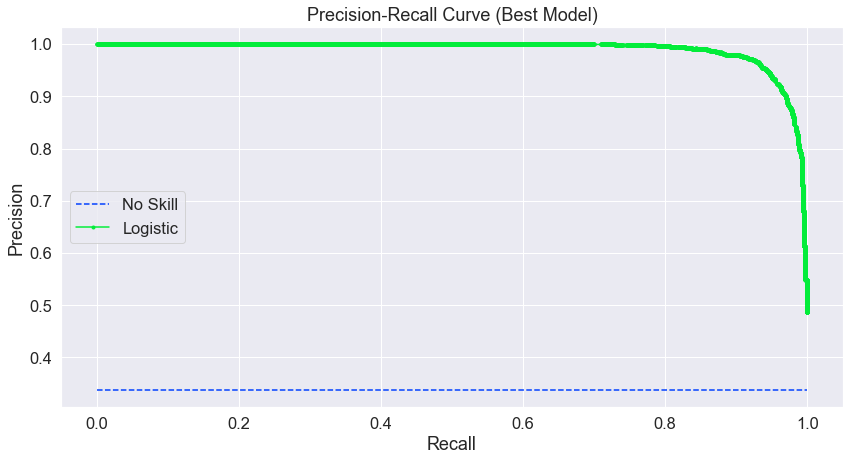

In [22]:
# predict probabilities
lr_probs = best_model.predict_proba(X_test_tfidf)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 2]
# predict class values
yhat = best_model.predict(X_test_tfidf)
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs, pos_label = 'positive')
lr_f1= f1_score(y_test, yhat, average = 'micro', pos_label = 'positive')
lr_auc = auc(lr_recall, lr_precision)
# summarize scores
print('Multinomial Naive Bayes with TF-IDF: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))

# plot the precision-recall curves
no_skill = len(y_test[y_test=="positive"]) / len(y_test)
plt.figure(figsize=(14, 7))
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')
plt.title("Precision-Recall Curve (Best Model)")
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

### Model saving as pickle file as well as loading model (Best-performing model)

Both the trained model and the feature extraction algorithm are saved to the defined filepath destination as pickle file which can be loaded when needed.

In [23]:
# #uncomment the codes below when necessary

# #declare file name for the best model and vectorizer
# model_filename = 'best_model.pkl'
# vector_filename = 'best_vectorizer.pkl'
# #export and save both model and vectorizer into respective pkl file
# pickle.dump(best_model, open(model_filename, 'wb'))
# pickle.dump(best_vec, open(vector_filename, 'wb'))

# # This section is to demonstrate how to load the model and apply the model
# # load the model and vectorizer from respective file in given filename/directory
# loaded_model = pickle.load(open('best_model.pkl', 'rb'))
# loaded_vector = pickle.load(open('best_vectorizer.pkl', 'rb'))
# X_train_tfidf2 = loaded_vector.fit_transform(X_train["clean_text"])
# X_test_tfidf2 = loaded_vector.transform(X_test["clean_text"])
# result = loaded_model.score(X_test_tfidf2, y_test)
# print("Naive Bayes with TFIDF (accuracy score): %.2f%%" %(result * 100))

### LIME Explainable AI to interpret the result of the prediction made by the model

LIME Explainable AI allows for a much deeper understading towards the model as it shows us how does the model predicts the input tweet and the prediction probability made by the model. This allows for a greater trust to be developed between the user and the model.

Input Tweet: Streaming @ Borderlands with sarcastic comments while I desperately try to get drunk. 3 hours in, my only viewers are myself and a friend who has it in another tab. Worst: I'm still sober! Pls send viewers... and vodka.. Twitch.tv / fbalfour

True sentiment: neutral
Predicted Class: neutral


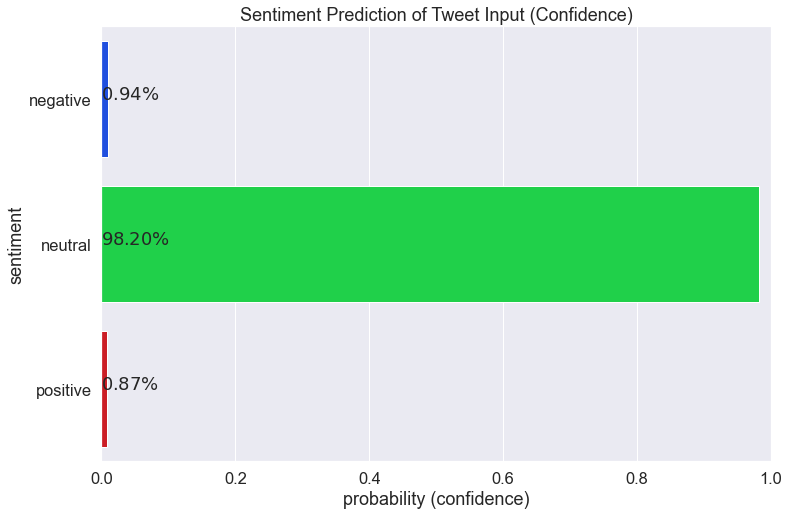

In [26]:
#selected row from original dataset to explain machine model (change the value of the variable to choose row)
idx = 1231

#define class name to classify text data from selected row
class_names = ['negative', 'neutral', 'positive']
best_model_pipe = make_pipeline(best_vec, best_model)
review_text = df_tweets.text[idx]
true_sentiment = df_tweets.sentiment.iloc[idx]

#calculate probability
proba = best_model_pipe.predict_proba([df_tweets.text[idx]])[0]

#display side bar graph with prediction probability/confidence of tweet input
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': proba })
print("Input Tweet:", review_text)
print(f'\nTrue sentiment: {true_sentiment}') #sentiment for tweet example retrieved from dataset (comment if unnecessary)
print('Predicted Class: %s' % best_model_pipe.predict([df_tweets.text[idx]])[0])
plt.figure(figsize=(12,8))
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
#value of probability prediction (converted into percentage)
plt.text(0, 0, r'${0:2.2f}\%%$'.format(proba[0]*100))
plt.text(0, 1, r'${0:2.2f}\%%$'.format(proba[1]*100))
plt.text(0, 2, r'${0:2.2f}\%%$'.format(proba[2]*100))
plt.title('Sentiment Prediction of Tweet Input (Confidence)')
plt.ylabel('sentiment')
plt.xlabel('probability (confidence)')
plt.xlim([0, 1])
plt.show()

Probability(neutral) = 0.9819872417214184
Probability(positive) = 0.008653758863371103
Probability(negative) = 0.009358999415207181


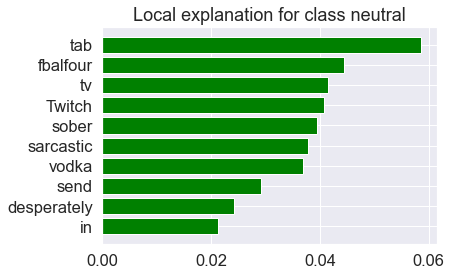

In [27]:
explainer = LimeTextExplainer(class_names = class_names)

#use lime to explain the prediction made by the logistic model and display the results
exp = explainer.explain_instance(df_tweets.text[idx], best_model_pipe.predict_proba, num_features = 10, top_labels=3)
print(f"Probability(neutral) = {best_model_pipe.predict_proba([df_tweets.text[idx]])[0,1]}")
print(f"Probability(positive) = {best_model_pipe.predict_proba([df_tweets.text[idx]])[0,2]}")
print(f"Probability(negative) = {best_model_pipe.predict_proba([df_tweets.text[idx]])[0,0]}")
exp.show_in_notebook(text=True)
fig = exp.as_pyplot_figure()

## Conclusion

The twitter sentiment analysis model performs best when multinomial naive bayes algorithm and TF-IDF feature extraction algorithm is used as the algorithm of the model.